In [1]:
#import section
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import warnings
from sklearn.cluster import DBSCAN
warnings.filterwarnings(action='ignore')
%matplotlib inline

### Load Event CSVs into Pandas Dataframe

In [2]:
#show the full content of the column
pd.set_option('display.max_colwidth', -1)

In [3]:
#read latest events dataset into pandas dataframe
dfev = pd.read_csv('events_init2.csv', encoding='utf-8')

In [4]:
dfev.shape

(858777, 9)

In [5]:
#print 5 rows from dataframe
dfev.head(5)

,device_id,event_id,event_time,latitude,longitude,gender,age,group_train,age_group
0,4676982795249940000,2958924,2016-05-01 22:03:46,113.24,22.85,M,52,M32+,32+
1,4782582047729160000,2958931,2016-05-01 22:24:09,114.47,38.03,M,36,M32+,32+
2,2181284491650730000,2958933,2016-05-01 22:24:44,125.66,43.02,M,28,M25-32,25-32
3,4221762657972680000,2958935,2016-05-01 22:40:47,115.19,24.07,F,19,F0-24,0-24
4,-6242501228649110000,2958939,2016-05-01 21:59:40,111.21,27.85,M,20,M0-24,0-24


#### Observation:  From the below graph, the cluster formation will be within the range of
    Latitude - 20 to 50
    Longitude - 80 to 120

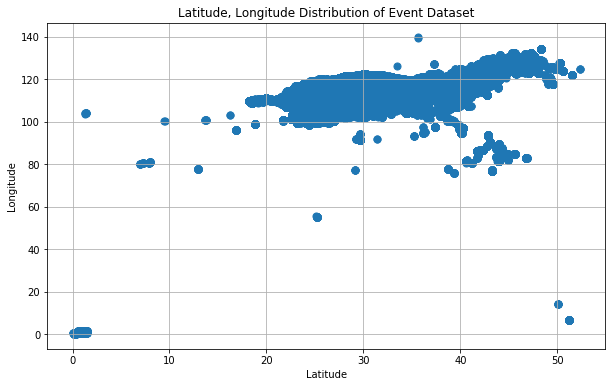

In [6]:
#plot the distribution of latitude, longitude of event data
plt.figure(figsize=(10, 6))
plt.scatter(dfev['longitude'],dfev['latitude'], s = 50)
plt.grid(True)
plt.title('Latitude, Longitude Distribution of Event Dataset')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [7]:
#take only unique latitude, longitude coordinates
dfsub = dfev[['longitude','latitude']]
print('before dropping duplicates =',dfsub.shape)
dfsub.drop_duplicates(inplace=True)
print('after dropping duplicates=',dfsub.shape)

before dropping duplicates = (858777, 2)
after dropping duplicates= (32855, 2)


In [8]:
#convert latitude, longitude to numpy co-ordinates
coords = dfsub[['longitude','latitude']].to_numpy()
coords.shape

(32855, 2)

In [9]:
coords.min(), coords.max()

(0.01, 139.56)

In [10]:
#drop duplicate latitude & longitude coordination.
unique_coords = np.unique(coords, axis=0)
unique_coords.shape

(32855, 2)

In [11]:
unique_coords.min(), unique_coords.max()

(0.01, 139.56)

In [12]:
unique_coords

array([[1.0000e-02, 4.8000e-01],
       [1.1000e-01, 7.0000e-02],
       [1.4000e-01, 2.3000e-01],
       ...,
       [5.1560e+01, 1.2173e+02],
       [5.1560e+01, 1.2174e+02],
       [5.2320e+01, 1.2470e+02]])

In [13]:
#convert lat,long coordinates into radians
latlong_radians = np.radians(unique_coords)
latlong_radians

array([[1.74532925e-04, 8.37758041e-03],
       [1.91986218e-03, 1.22173048e-03],
       [2.44346095e-03, 4.01425728e-03],
       ...,
       [8.99891762e-01, 2.12458930e+00],
       [8.99891762e-01, 2.12476383e+00],
       [9.13156265e-01, 2.17642558e+00]])

In [14]:
#compute DBScan.  min_samples = 1 ensures there will be no outliers.
kms_per_radian = 6371.0088
#epsilon = 1.5/kms_per_radian
#eps 10, min_sample 200 : 10, 1
#best so far eps=.1, min_samples=150,results 3 cluster
#  eps=.05, min_samples=20,results 4 cluster
#  eps=.025, min_samples=10,results 8 cluster
epsilon = 5/kms_per_radian
db = DBSCAN(eps = 0.025, min_samples = 10, algorithm = 'ball_tree', metric = 'haversine').fit(latlong_radians)

In [15]:
cluster_labels = db.labels_
n_clusters = len(set(cluster_labels))
print('Number of clusters:', n_clusters, ' cluster ids=',set(cluster_labels))

Number of clusters: 8  cluster ids= {0, 1, 2, 3, 4, 5, 6, -1}


In [16]:
#update the cluster id in subset dataframe first
dfsub['cluster_id'] = db.labels_
dfsub['cluster_id'] = dfsub['cluster_id']
dfsub['cluster_id'].value_counts(ascending=False)

 1    32266
 6    198  
 0    150  
-1    95   
 3    92   
 5    26   
 4    15   
 2    13   
Name: cluster_id, dtype: int64

In [17]:
#cluster id -1 means outlier.  Check for outlier existance.
dfsub[dfsub['cluster_id'] == -1]

,longitude,latitude,cluster_id
137,37.83,112.53,-1
142,34.28,108.97,-1
151,36.11,114.37,-1
152,34.54,116.79,-1
174,28.20,113.03,-1
...,...,...,...
858236,32.51,119.92,-1
858424,34.31,112.41,-1
858463,27.21,111.44,-1
858608,29.30,117.19,-1


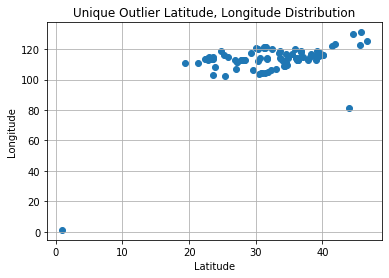

In [18]:
#plot the outlier cluster
#.plot(kind='scatter', dfsub['longitude'], dfsub['latitude'])
x = dfsub[dfsub['cluster_id'] == -1]['longitude']
y = dfsub[dfsub['cluster_id'] == -1]['latitude']
plt.scatter(x, y)
plt.grid(True)
plt.title('Unique Outlier Latitude, Longitude Distribution')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

#### Adding cluster_id as a feature in  event dataset

In [19]:
#initialise cluster id in event dataset
dfev['cluster_id'] = -1

#Iterate the subset. read the cluster id for a unique lat, lng combination and assign the cluster id to event dataset.
for idx, row in dfsub.iterrows():
    cluster_id = row.cluster_id
    lng = row.longitude
    lat = row.latitude
    #dfsub.at[idx,'cluster_id'] = cluster_id
    dfev.loc[((dfev['longitude'] == lng) & (dfev['latitude'] == lat)),['cluster_id']] = cluster_id
    print('processing subset row:',idx,': cluster id ',cluster_id, 'updated in event dataset')
    #break;

processing subset row: 0 : cluster id  0.0 updated in event dataset
processing subset row: 1 : cluster id  0.0 updated in event dataset
processing subset row: 2 : cluster id  0.0 updated in event dataset
processing subset row: 3 : cluster id  0.0 updated in event dataset
processing subset row: 4 : cluster id  0.0 updated in event dataset
processing subset row: 5 : cluster id  0.0 updated in event dataset
processing subset row: 7 : cluster id  0.0 updated in event dataset
processing subset row: 8 : cluster id  0.0 updated in event dataset
processing subset row: 9 : cluster id  0.0 updated in event dataset
processing subset row: 10 : cluster id  0.0 updated in event dataset
processing subset row: 11 : cluster id  0.0 updated in event dataset
processing subset row: 12 : cluster id  0.0 updated in event dataset
processing subset row: 13 : cluster id  0.0 updated in event dataset
processing subset row: 14 : cluster id  0.0 updated in event dataset
processing subset row: 15 : cluster id  0.0

In [20]:
#verify the shape after updating cluster_id
dfev.shape

(858777, 10)

In [21]:
#view the dataset after updating cluster_id
dfev

,device_id,event_id,event_time,latitude,longitude,gender,age,group_train,age_group,cluster_id
0,4676982795249940000,2958924,2016-05-01 22:03:46,113.24,22.85,M,52,M32+,32+,0.0
1,4782582047729160000,2958931,2016-05-01 22:24:09,114.47,38.03,M,36,M32+,32+,0.0
2,2181284491650730000,2958933,2016-05-01 22:24:44,125.66,43.02,M,28,M25-32,25-32,0.0
3,4221762657972680000,2958935,2016-05-01 22:40:47,115.19,24.07,F,19,F0-24,0-24,0.0
4,-6242501228649110000,2958939,2016-05-01 21:59:40,111.21,27.85,M,20,M0-24,0-24,0.0
...,...,...,...,...,...,...,...,...,...,...
858772,3840188037865600000,2958903,2016-05-01 22:56:07,104.00,30.00,M,28,M25-32,25-32,0.0
858773,-2425938234947390000,2958904,2016-05-01 22:56:35,1.00,1.00,M,20,M0-24,0-24,0.0
858774,-4161937508714070000,2958908,2016-05-01 22:37:00,112.68,26.89,M,22,M0-24,0-24,1.0
858775,1758245324433640000,2958922,2016-05-01 22:10:57,115.84,28.67,M,46,M32+,32+,1.0


In [22]:
cluster_det = dfev['cluster_id'].value_counts(ascending=False)
cluster_det

 1.0    770503
 0.0    84072 
-1.0    3500  
 2.0    280   
 6.0    220   
 3.0    146   
 5.0    32    
 4.0    24    
Name: cluster_id, dtype: int64

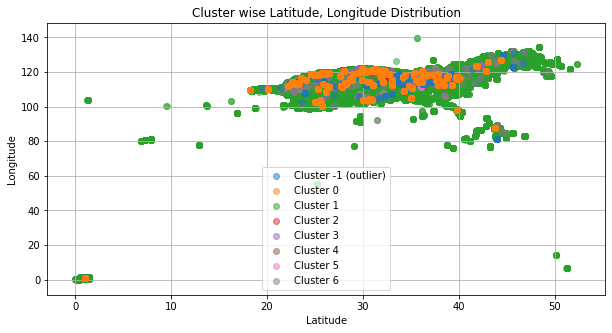

In [23]:
#Now that cluster is assigned to each co-ordinate.  plot the coordinates for each cluster
#.plot(kind='scatter', dfsub['longitude'], dfsub['latitude'])
plt.figure(figsize=(10,5))
plt.scatter(dfev[dfev['cluster_id'] == -1]['longitude'], dfev[dfev['cluster_id'] == -1]['latitude'], alpha = 0.5, zorder = 2, label='Cluster -1 (outlier)')
plt.scatter(dfev[dfev['cluster_id'] == 0]['longitude'], dfev[dfev['cluster_id'] == 0]['latitude'], alpha = 0.5, zorder =  2, label='Cluster 0')
plt.scatter(dfev[dfev['cluster_id'] == 1]['longitude'], dfev[dfev['cluster_id'] == 1]['latitude'], alpha = 0.5, zorder = 1, label='Cluster 1')
plt.scatter(dfev[dfev['cluster_id'] == 2]['longitude'], dfev[dfev['cluster_id'] == 2]['latitude'], alpha = 0.5, zorder = 1, label='Cluster 2')
plt.scatter(dfev[dfev['cluster_id'] == 3]['longitude'], dfev[dfev['cluster_id'] == 3]['latitude'], alpha = 0.5, zorder = 1, label='Cluster 3')
plt.scatter(dfev[dfev['cluster_id'] == 4]['longitude'], dfev[dfev['cluster_id'] == 4]['latitude'], alpha = 0.5, zorder = 1, label='Cluster 4')
plt.scatter(dfev[dfev['cluster_id'] == 5]['longitude'], dfev[dfev['cluster_id'] == 5]['latitude'], alpha = 0.5, zorder = 1, label='Cluster 5')
plt.scatter(dfev[dfev['cluster_id'] == 6]['longitude'], dfev[dfev['cluster_id'] == 6]['latitude'], alpha = 0.5, zorder = 1, label='Cluster 6')
plt.grid(True)
plt.title('Cluster wise Latitude, Longitude Distribution')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.show()

In [24]:
#save event dataframe to csv
dfev.to_csv(r'events_dbscan3.csv', index = False)

In [25]:
#upload events csv to S3
!aws s3 cp events_dbscan3.csv s3://capstone-sanjanameghna/final_submission/events_dbscan3.csv

upload: ./events_dbscan3.csv to s3://capstone-sanjanameghna/final_submission/events_dbscan3.csv
